# Testing clustering with the Porto Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans

/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df = pd.read_csv("../datasets/Dataset.csv", decimal=",")
df_index = pd.DataFrame(pd.date_range('2019-01-01', periods=35136, freq='15T'))
df = pd.concat([pd.DataFrame(df_index).rename(columns={0: "Time"}),df],axis=1)
df

,Time,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,50
0,2019-01-01 00:00:00,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2019-01-01 00:15:00,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,2019-01-01 00:30:00,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2019-01-01 00:45:00,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2019-01-01 01:00:00,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,2020-01-01 22:45:00,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,2020-01-01 23:00:00,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,2020-01-01 23:15:00,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,2020-01-01 23:30:00,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


In [3]:
# unique_locations = df['Location'].unique()
# lists_per_location = []
# for location in unique_locations:
#     values = df.loc[df['Location'] == location, 'Energy'].tolist()
#     lists_per_location.append(values)
# len(lists_per_location)

In [4]:
# x = lists_per_location[1]
# y = lists_per_location[2]
# formatted_dataset = to_time_series_dataset(lists_per_location[:5])
# formatted_dataset.shape

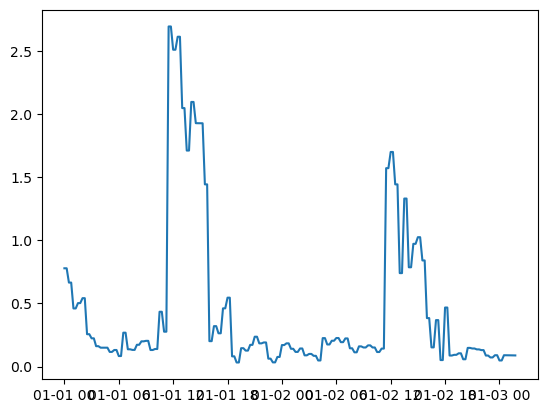

In [5]:
plt.plot(df.iloc[:200,0],df.iloc[:200,4])
plt.show()

In [6]:
undersample_data = df.loc[np.linspace(df.index.min(),df.index.max(),3000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

,Time,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,50
0,2019-01-01 00:00:00,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2019-01-01 02:45:00,3.047,2.443886,0.508011,0.255981,0.645293,2.816826,0.236496,0.685193,0.317444,...,0.945689,0.202642,0.220337,0.282918,0.874256,0.973139,0.217856,0.273284,1.042051,0.820053
2,2019-01-01 05:45:00,3.358,2.208429,0.259545,0.130782,0.329682,2.545438,0.086792,0.251459,0.209140,...,0.854576,0.074367,0.080861,0.186393,0.790025,0.879381,0.079951,0.100293,0.941654,0.741044
3,2019-01-01 08:45:00,2.578,2.244719,0.395647,0.199362,0.502565,2.587266,0.195787,0.567247,0.425748,...,0.868619,0.167760,0.182409,0.379444,0.803007,0.893832,0.180355,0.226243,0.957128,0.753222
4,2019-01-01 11:30:00,2.846,2.382500,5.347570,2.694579,6.792662,2.746072,0.414973,1.202286,0.179262,...,0.921935,0.355569,0.386618,0.159766,0.852296,0.948695,0.382264,0.479524,1.015876,0.799454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2020-01-01 12:00:00,1.667,1.290956,0.246884,0.124402,0.313600,1.487958,1.117284,3.237067,0.130712,...,0.499550,0.957343,1.040941,0.116496,0.461816,0.514050,1.029218,1.291082,0.550452,0.433184
2996,2020-01-01 14:45:00,1.697,0.885487,0.324431,0.163477,0.412103,1.020614,1.712793,4.962414,0.268894,...,0.342649,1.467604,1.595760,0.239649,0.316767,0.352595,1.577789,1.979225,0.377564,0.297128
2997,2020-01-01 17:45:00,1.679,1.535517,3.203161,1.614036,4.068762,1.769839,0.989035,2.865495,0.276363,...,0.594185,0.847453,0.921455,0.246305,0.549303,0.611433,0.911078,1.142883,0.654731,0.515247
2998,2020-01-01 20:45:00,1.659,1.589276,1.436991,0.724083,1.825314,1.831802,1.660324,4.810397,0.052285,...,0.614988,1.422646,1.546876,0.046598,0.568535,0.632839,1.529456,1.918594,0.677653,0.533286


Text(0, 0.5, 'Temperature')

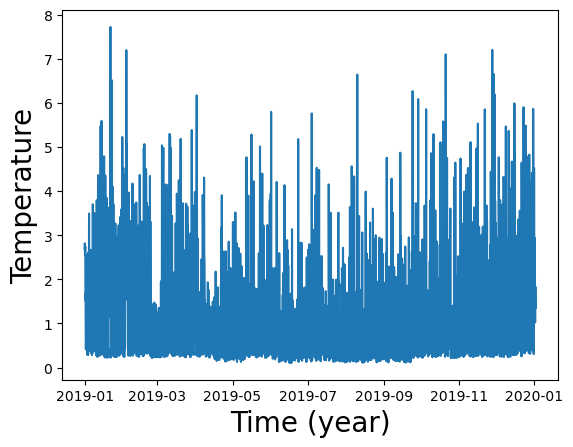

In [7]:
plt.plot(undersample_data.Time,undersample_data["5"])
plt.xlabel('Time (year)',fontsize=20)
plt.ylabel('Temperature',fontsize=20)

In [ ]:
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X = scaler.fit_transform(X)

In [8]:
n_clusters = 5

In [9]:
data_array = np.array(undersample_data.T.drop('Time').values)
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, n_init=10, dtw_inertia=True)
model.fit(data_array)
cities_list = undersample_data.T.drop('Time').index.tolist()

In [ ]:
y=model.predict(data_array)

/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 51 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [11]:
y

array([1, 4, 2, 0, 3, 4, 0, 3, 0, 3, 0, 3, 4, 0, 2, 2, 0, 0, 2, 0, 0, 2,
       0, 4, 2, 2, 2, 0, 2, 3, 4, 0, 3, 4, 2, 0, 2, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [11]:
# 5 clusters
# array([2, 3, 4, 1, 4, 3, 1, 0, 1, 0, 1, 0, 4, 1, 4, 3, 1, 1, 3, 1, 1, 1,
#      1, 3, 1, 3, 3, 1, 1, 0, 3, 1, 0, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1,
#       1, 1, 1, 1, 1, 1, 1])

In [12]:
# 4 clusters
# array([1, 2, 3, 0, 3, 2, 0, 2, 0, 2, 0, 2, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0,
#      0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0, 0, 0])

In [13]:
# Executed with 1-hour intervals
#y = np.array([1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#       0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0, 0, 0])

In [14]:
# Executed with 1500 records linearly spaced
#y = np.array([2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
#      0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0, 0, 0])

In [12]:
x = undersample_data['Time']

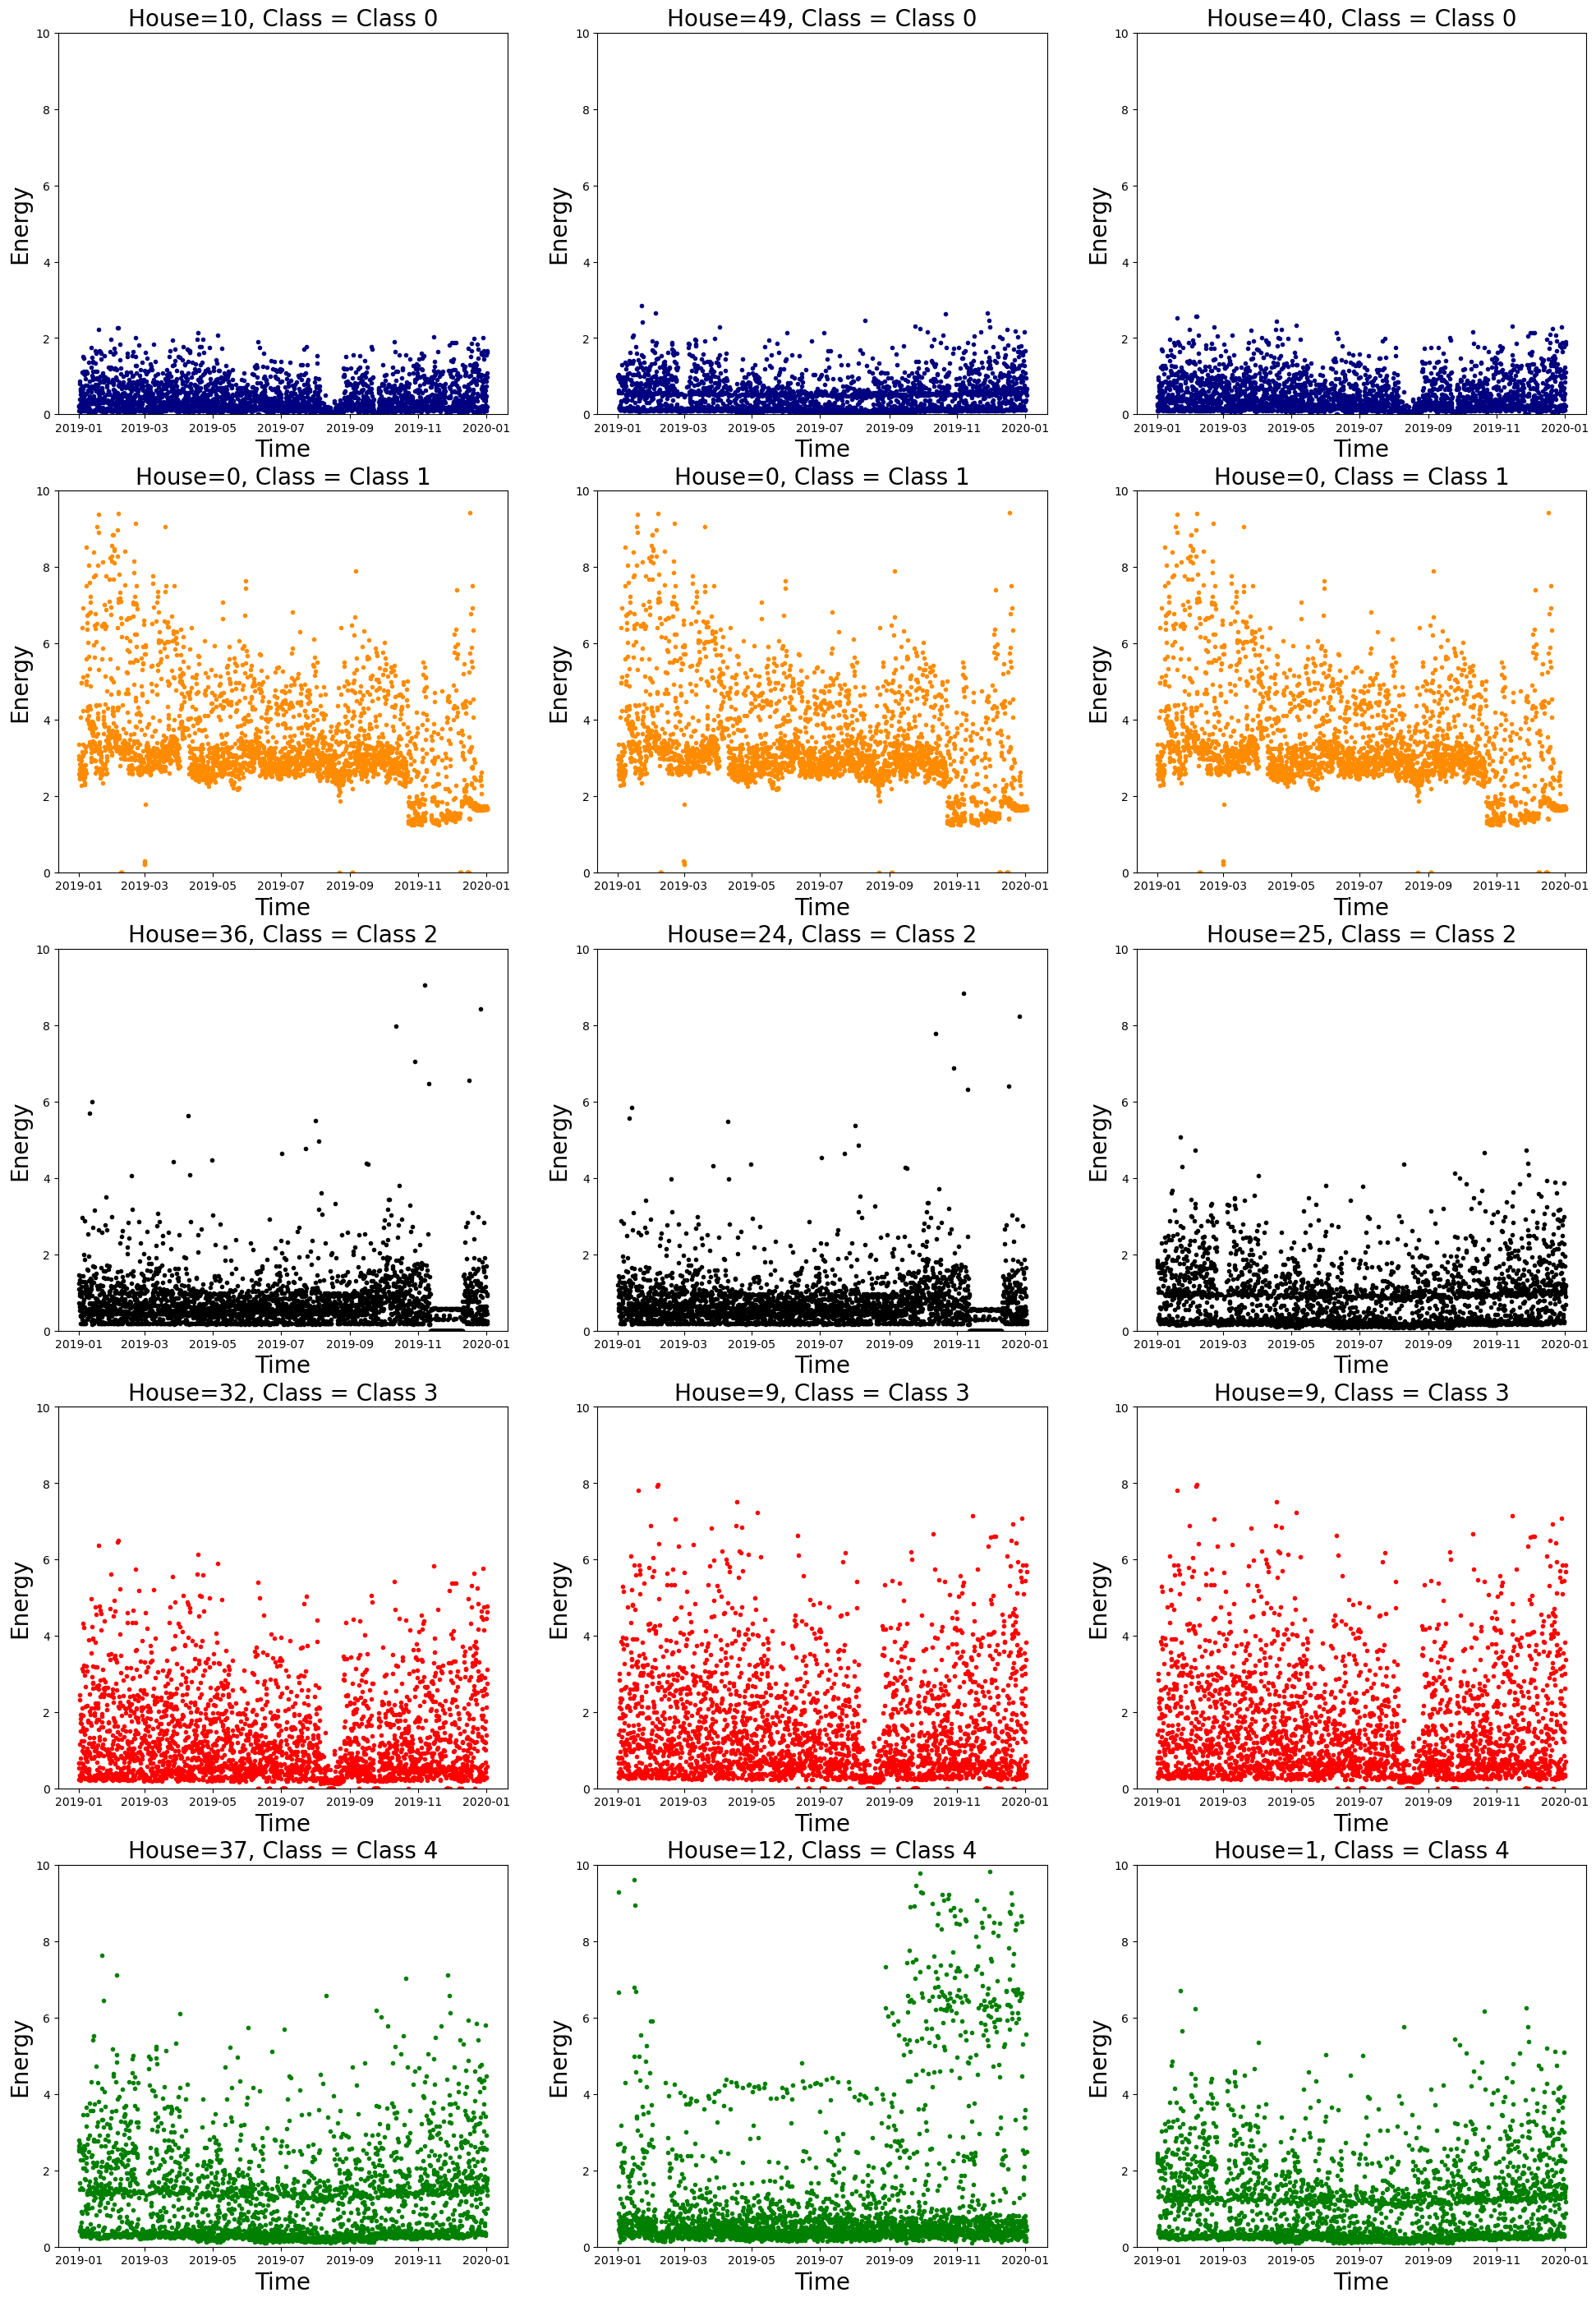

In [15]:
plt.figure(figsize=(24,35))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2,'10':3, '11':3, '12':3, '13':4, '14':4, '15':4}
colors = ['navy']*3+['darkorange']*3+['k']*3+['red']*3+['green']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3+['Class 3']*3+['Class 4']*3
for j in range(1,16):
    plt.subplot(5,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,data_array[k],'.',color=colors[j-1])
    plt.ylabel('Energy',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('House=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(0,10)

In [16]:
cluster_list = []
for i in range(0,n_clusters):
    cluster_list.append(np.where(y == i)[0])
len(cluster_list)

5

In [19]:
string = "cluster"
for i in range(len(cluster_list)):
    st = string + str(i)
    locals()[st] = cluster_list[i]
    print(cluster_list[i])

[ 3  6  8 10 13 16 17 19 20 22 27 31 35 38 39 40 41 42 43 44 45 46 47 48
 49 50]
[0]
[ 2 14 15 18 21 24 25 26 28 34 36]
[ 4  7  9 11 29 32]
[ 1  5 12 23 30 33 37]


In [19]:
#cluster0.to_csv("data/.csv", index=None)

In [22]:
#cluster2.to_csv("data/.csv", index=None)

In [23]:
## Compare gains of cluster with normal runs